In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import joblib
import os


In [2]:
# memuat dataset
train_df = pd.read_csv("dataset/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("dataset/DailyDelhiClimateTest.csv")

# Gabungkan keduanya agar data lengkap (2013–2017)
df = pd.concat([train_df, test_df])

# Pastikan format tanggal
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Tampilkan 5 data pertama
print("5 Data Teratas:")
display(df.head())

5 Data Teratas:


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


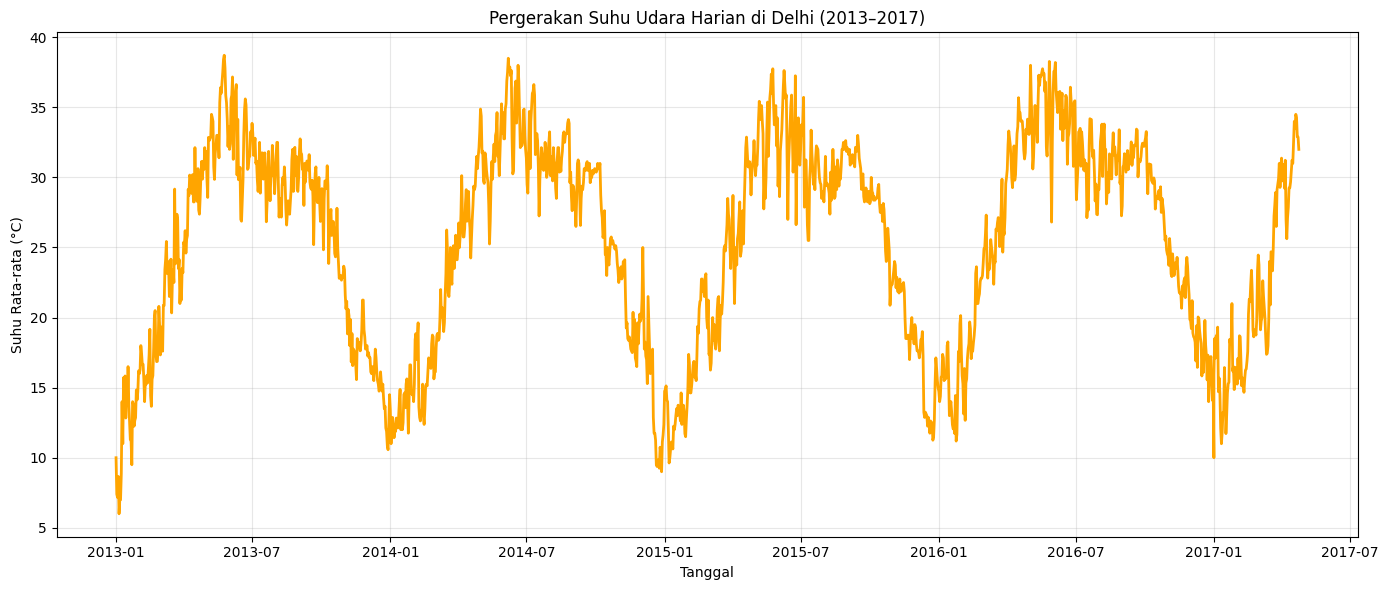

In [3]:
# visualisasi data awal
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['meantemp'], color='orange', linewidth=2)
plt.title('Pergerakan Suhu Udara Harian di Delhi (2013–2017)')
plt.xlabel('Tanggal')
plt.ylabel('Suhu Rata-rata (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# normalisasi data
temperature_data = df['meantemp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temperature_data)

In [5]:
# membentuk data time series
timesteps = 60
X = []
y = []

for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data[i - timesteps:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Bentuk ke 3D [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("Bentuk Data untuk LSTM:", X.shape, y.shape)


Bentuk Data untuk LSTM: (1516, 60, 1) (1516,)


In [6]:
# membagi data Train dan Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
# membangun arsitektur LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# melatih model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0974 - val_loss: 0.0075
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 0.0048
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0082 - val_loss: 0.0048
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


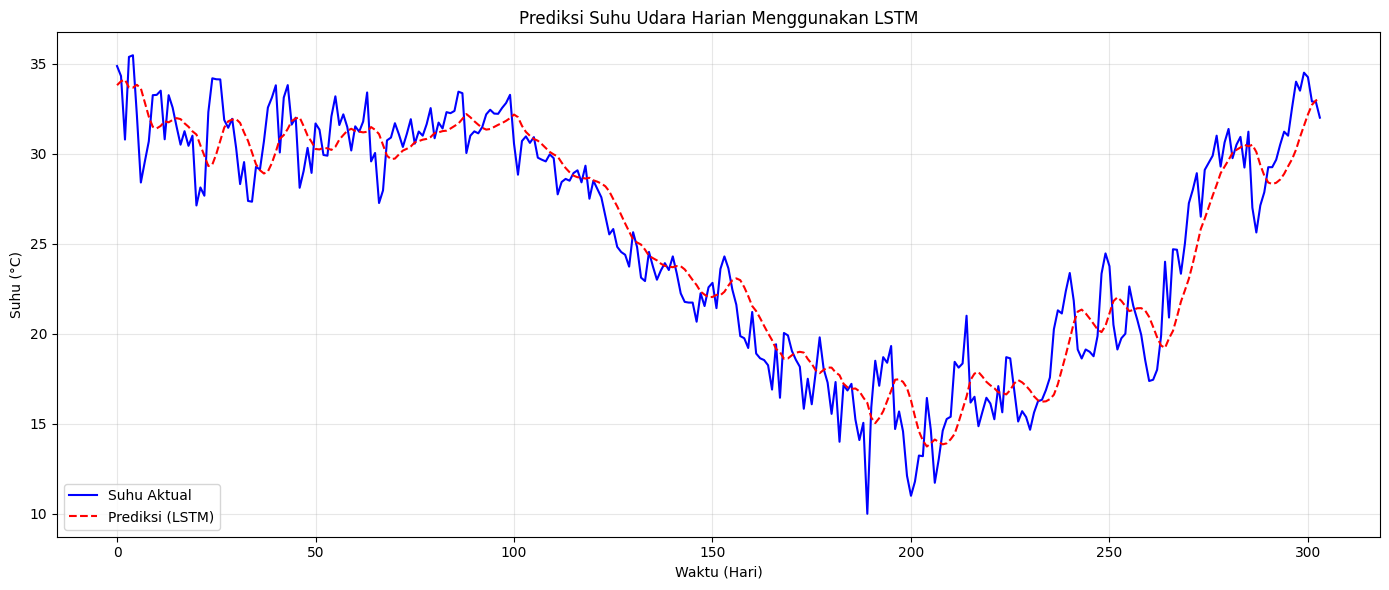

In [10]:
# prediksi dan visualisasi
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, color='blue', label='Suhu Aktual')
plt.plot(predictions, color='red', linestyle='--', label='Prediksi (LSTM)')
plt.title('Prediksi Suhu Udara Harian Menggunakan LSTM')
plt.xlabel('Waktu (Hari)')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# evaluasi model
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
print(f"Nilai Root Mean Squared Error (RMSE): {rmse:.2f}")


Nilai Root Mean Squared Error (RMSE): 2.04


In [12]:
# simpan model dan scaler
os.makedirs('models', exist_ok=True)

model.save('models/lstm_model.h5')
joblib.dump(scaler, 'models/scaler.pkl')

print("✅ Model dan scaler berhasil disimpan di folder 'models/'")

✅ Model dan scaler berhasil disimpan di folder 'models/'
